## Tesis CCS COMPUTACIÓN UNSA

#### Ing. Vargas Mauricio


##### Hibrido BiLSTM + distilBERT (BERT para Feature Extraction) 

##### DS Procesado

In [1]:
from tensorflow.keras.optimizers import Adam

#!/usr/bin/env python
# coding: utf-8

import tensorflow as tf
import pandas as pd
from tensorflow import keras
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import BertConfig
from transformers import TFBertForSequenceClassification
from timeit import default_timer as timer
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import datasets
from datasets import load_dataset
from keras.callbacks import EarlyStopping

C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [3]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
cd F:\Maestria\TESIS\

F:\Maestria\TESIS


In [5]:
df= pd.read_csv('./BD_POL/data_extended.csv')
df.head()

,Unnamed: 0,full_text,POS,clean_text,label,text_changed
0,0,"Sin ser fan de Juan Gabriel, siempre supe que ...",P,fan juan gabriel supe fuerza naturaleza escuch...,2,fan juan gabriel supe naturaleza escuche quer...
1,1,Sabes que no tendrás un buen día cuando lo pri...,N,tendras ana tratar cambiar foco cae cara,0,tendras ana tratar cambiar foco cae caradura
2,2,"En situaciones en las que no sepas que hacer, ...",N,situaciones sepas sumergete podras escuchar al...,0,situaciones situaciones sepas sumergete podra...
3,3,ayer preguntaban y dónde están las solteras!!!...,NEU,preguntaban solteras grupo alza mano unica vol...,1,preguntaban solteras grupo alza alza alza man...
4,4,Que el finde sea para hacer cualquier cosa que...,NEU,finde cosa haga feliz reverenda gana,1,finde elemento haga feliz reverenda gana


In [6]:
df_w = df[["label", "text_changed"]]

In [7]:
df_w['text_changed'] = df_w['text_changed'].str.lower()
df_w["text_changed"] = df_w["text_changed"].str.replace(r'\s*https?://\S+(\s+|$)', ' ').str.strip()
df_w['text_changed'] = df_w['text_changed'].str.replace(
    r'[^a-z0-9\s]',
    '',
    regex=True,
    flags=re.IGNORECASE
)

df_w = df_w.dropna()

C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C

In [8]:
df_w.head()

,label,text_changed
0,2,fan juan gabriel supe naturaleza escuche quer...
1,0,tendras ana tratar cambiar foco cae caradura
2,0,situaciones situaciones sepas sumergete podras...
3,1,preguntaban solteras grupo alza alza alza man...
4,1,finde elemento haga feliz reverenda gana


In [9]:
df_w = df_w.sample(frac=1, random_state = 1) 

In [10]:
df_w.head()

,label,text_changed
5019,2,rio caray despues pense iba feliz
35666,0,entendido significado septiembre tramo capital...
33960,1,peru propuestas mauricio mulder apra reforma p...
15090,0,altero mauricio mauricio mulder dijero pusier...
18918,1,lazo lazo feliz


In [11]:
df_w = df_w.rename(columns={"label": "category"})

for column in df_w.columns:
    if column == "full_text":
        df_w = df_w.rename(columns={"full_text":"text_changed"})
    else:
        pass
## Cambiar aca, SOLO si usas "SIN preprocess", sino, ignorar

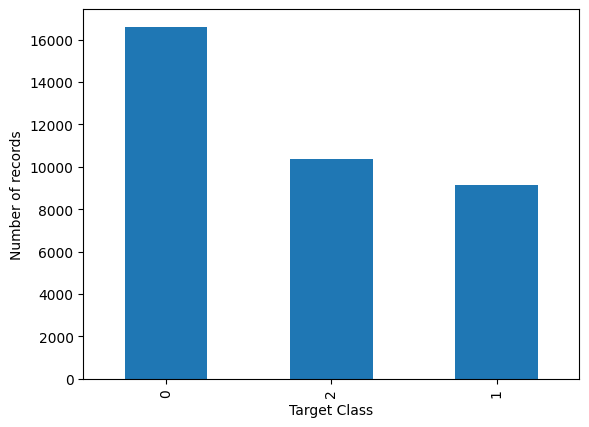

In [12]:
#viewing class distribution
y = df_w['category']

count = y.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()


In [13]:
def map_to_categorical(df):
    # Generate number representation for category field
    df['label'] = pd.Categorical(df.category, ordered=True).codes
    df['label'].unique()

    # Map labels to human readable category inside a dictionary
    mapLabels = pd.DataFrame(df.groupby(['category', 'label']).count())

    #drop count column
    mapLabels.drop(['text_changed'], axis = 1, inplace = True)
    label2Index = mapLabels.to_dict(orient='index')

    print (f"label2Index :{label2Index}")
    print (type(label2Index))
    #print (f"index2Label :{index2Label}")

    # generate inverse dictionary to map in both directions
    index2label = {}

    for key in label2Index:
      '''
      print (f"{key[1]} -> {key[0]}")
      '''
      index2label[key[1]] = key[0]

    label2Index = {v: k for k, v in index2label.items()}
    print(label2Index)

    df.rename(columns = {'label' : 'labels', 'text_changed' : 'text'}, inplace = True)

    df = df[['text','labels']]
    return df, label2Index, index2label

In [14]:
df, label2Index, index2label =  map_to_categorical(df_w)

label2Index :{(0, 0): {}, (1, 1): {}, (2, 2): {}}
<class 'dict'>
{0: 0, 1: 1, 2: 2}


In [15]:
# whole_data = np.array(df)

In [16]:
df.head(2)

,text,labels
5019,rio caray despues pense iba feliz,2
35666,entendido significado septiembre tramo capital...,0


In [17]:
# One Hot Encode a continues label value (eg. 0-4)

def one_hot_encoding_labels(df):
    arr = df['labels'].values
    
    labels = np.zeros((arr.size, arr.max() + 1), dtype=int)    
    labels[np.arange(arr.size), arr] = 1
    '''
    for i in range(0, 20):
        print(labels[i])
    '''   
    return labels, arr

In [18]:
labels, arr = one_hot_encoding_labels(df)

In [19]:
#Encode Text Input Data
seqlen = df['text'].apply(lambda x: len(x.split()))

# Maximum length of the text we are going to train and predict here
SEQ_LEN = 256

In [20]:
from transformers import DistilBertTokenizerFast

def tokenize_data(SEQ_LEN, df):
    # initialize numpy arrays for Token-Ids and Attention Masks
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-multilingual-cased")

    Xids = np.zeros((len(df), SEQ_LEN), dtype=int)
    Xmask = np.zeros((len(df), SEQ_LEN), dtype=int)
    for i, sequence in enumerate(df['text']):
      tokens = tokenizer.encode_plus(sequence
                                   ,max_length = SEQ_LEN          
                                   ,truncation=True               
                                   ,padding='max_length'          
                                   ,add_special_tokens=True       
                                   ,return_token_type_ids = False 
                                   ,return_attention_mask = True
                                   ,return_tensors='tf')

      Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']
    
    return Xids, Xmask, tokenizer

In [21]:
# for i, sequence in enumerate(df['text']):
#     print(i)
#     print(sequence)

In [22]:
Xids, Xmask, tokenizer = tokenize_data(SEQ_LEN, df)

In [23]:
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [24]:
#creating dataset to be fed into bert
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
dataset = dataset.map(map_func)

In [25]:
dataset

<MapDataset shapes: ({input_ids: (256,), attention_mask: (256,)}, (3,)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [26]:
#data split
def data_split(dataset):
    DS_LEN = len(list(dataset))
    
    SPLIT = .90

    # take or skip the specified number of batches to split by factor
    test = dataset.skip(round(DS_LEN * SPLIT)).batch(32)
    trainevalu = dataset.take(round(DS_LEN * SPLIT))

    DS_LEN2 = len(list(trainevalu))

    train = trainevalu.take(round(DS_LEN2 * SPLIT)).shuffle(100).batch(32).repeat(2)
    evalu = trainevalu.skip(round(DS_LEN2 * SPLIT)).batch(32)
    
    return test, train, evalu, DS_LEN

In [27]:
test, train, evalu, DS_LEN = data_split(dataset)

In [30]:
from transformers import TFDistilBertForSequenceClassification

def build_model():
    tranformersPreTrainedModelName = 'distilbert-base-multilingual-cased'
    bertConfig = BertConfig.from_pretrained(tranformersPreTrainedModelName
                                            , output_hidden_states=True
                                            , num_lables=3
                                            , max_length=SEQ_LEN
                                            , label2id=label2Index
                                            , id2label=index2label
                                            )

    
    bert = TFDistilBertForSequenceClassification.from_pretrained(tranformersPreTrainedModelName, config=bertConfig)
    return bert

In [31]:
bert = build_model()

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert

In [32]:
def add_inputLayers_to_model(SEQ_LEN, bert):
    # build 2 input layers to Bert Model where name needs to match the input values in the dataset
    input_ids = tf.keras.Input(shape=(SEQ_LEN,), name = 'input_ids', dtype='int32')
    mask = tf.keras.Input(shape=(SEQ_LEN,), name = 'attention_mask', dtype='int32')

    embedings = bert.layers[0](input_ids, attention_mask=mask)[0]   ### ACA ESTA LA CLAVE

    X = tf.keras.layers.Dropout(0.2)(embedings)
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768))(X)
    X = tf.keras.layers.Dropout(0.3)(X)
    y = tf.keras.layers.Dense(len(label2Index), activation='softmax', name='outputs')(X)

    model = tf.keras.Model(inputs=[input_ids,mask], outputs=y)
    
    return model

In [33]:
model = add_inputLayers_to_model(SEQ_LEN, bert)
model.layers[2].trainable = False

In [34]:
#training our model
def train_model(model, train, evalu):
    loss=    tf.keras.losses.CategoricalCrossentropy() ## Este es para one hot encode tal y como los tensoriza los labels
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5)
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['accuracy']
        )

    start = timer()

    earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
    
    history = model.fit(train
                        , validation_data=evalu
                        , epochs=11
                        , callbacks=[earlyStop])

    end = timer()
    print("Training for 3 classes on Peruvian DS with distilBERT-BiLSTM: ", timedelta(seconds=end-start))
    
    return model, history

In [35]:
model, history = train_model(model, train, evalu)

Epoch 1/11
1830/1830 [==============================] - 259s 140ms/step - loss: 0.7566 - accuracy: 0.6623 - val_loss: 0.5340 - val_accuracy: 0.7745
Epoch 2/11
1830/1830 [==============================] - 262s 143ms/step - loss: 0.3694 - accuracy: 0.8515 - val_loss: 0.2639 - val_accuracy: 0.8960
Epoch 3/11
1830/1830 [==============================] - 256s 140ms/step - loss: 0.1872 - accuracy: 0.9283 - val_loss: 0.2199 - val_accuracy: 0.9173
Epoch 4/11
1830/1830 [==============================] - 251s 137ms/step - loss: 0.1256 - accuracy: 0.9539 - val_loss: 0.1798 - val_accuracy: 0.9345
Epoch 5/11
1830/1830 [==============================] - 248s 136ms/step - loss: 0.0950 - accuracy: 0.9656 - val_loss: 0.1770 - val_accuracy: 0.9431
Epoch 6/11
1830/1830 [==============================] - 252s 138ms/step - loss: 0.0817 - accuracy: 0.9703 - val_loss: 0.2010 - val_accuracy: 0.9354
Epoch 7/11
1830/1830 [==============================] - 248s 136ms/step - loss: 0.0679 - accuracy: 0.9756 - val_

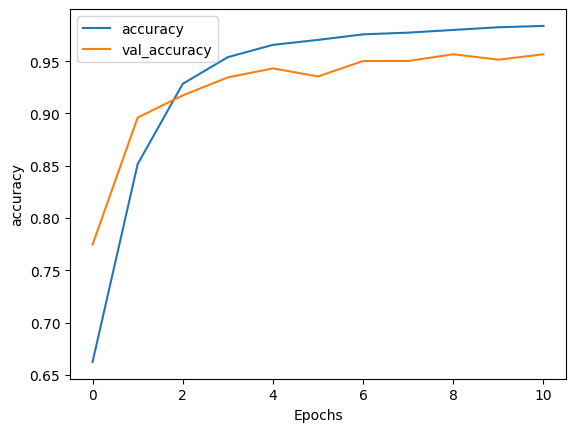

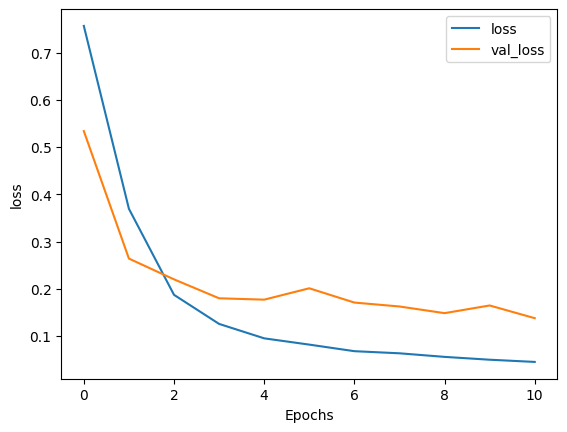

In [36]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Guardamos el modelo

In [37]:
model.save("modelo_hibrido_CON_preprocessing")
tokenizer.save_pretrained("modelo_hibrido_CON_preprocessing")

INFO:tensorflow:Assets written to: modelo_hibrido_CON_preprocessing\assets


INFO:tensorflow:Assets written to: modelo_hibrido_CON_preprocessing\assets
C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


('modelo_hibrido_CON_preprocessing\\tokenizer_config.json',
 'modelo_hibrido_CON_preprocessing\\special_tokens_map.json',
 'modelo_hibrido_CON_preprocessing\\vocab.txt',
 'modelo_hibrido_CON_preprocessing\\added_tokens.json',
 'modelo_hibrido_CON_preprocessing\\tokenizer.json')

#### Cargamos el modelo

In [30]:
import tensorflow as tf
from transformers import AutoTokenizer

model_load_path = './modelo_hibrido_CON_preprocessing'

# 1. Define the custom objects needed for the LSTM cells
#    Since your BiLSTM uses the standard Keras LSTM layer, you just pass that layer.
custom_objects = {
    'LSTM': tf.keras.layers.LSTM
}

# 2. Load the model using custom_objects
loaded_model = tf.keras.models.load_model(
    model_load_path, 
    custom_objects=custom_objects
)

# 3. Load the tokenizer (no changes here)
loaded_tokenizer = AutoTokenizer.from_pretrained(model_load_path)

In [31]:
loaded_tokenizer

PreTrainedTokenizerFast(name_or_path='./modelo_hibrido_CON_preprocessing', vocab_size=119547, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

## Testeamos

In [32]:
evalu

<BatchDataset shapes: ({input_ids: (None, 256), attention_mask: (None, 256)}, (None, 3)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [33]:
# Evaluation
results = loaded_model.evaluate(evalu)
# results = model.evaluate(evalu)
print("test loss, test accuracy:", results)

102/102 [==============================] - 10s 93ms/step - loss: 0.1377 - accuracy: 0.9566
test loss, test accuracy: [0.1377386748790741, 0.9566287398338318]


In [34]:

#extracting test labels and predicted labels
def extract_labels(test, predictions):
    test_len = len(list(test))
    count_batch  = 0     
    y_pred = []#store predicted label
    y_test = []#store test label
   
    batch_size = 32
    check_batch = 0
    out_of_bounds = len(predictions)%batch_size 
    index = 0

    for item in test.take(test_len):

        check_batch = check_batch+1

        for i in range(batch_size):
            if check_batch == test_len and i==out_of_bounds:
                break

            actualLabelIdx=np.argmax(item[1][i])

            index = batch_size*count_batch+i #index of a prediction

            predicLabelIdx=np.argmax(predictions[index])

            y_pred.append(predicLabelIdx)
            y_test.append(actualLabelIdx)

        count_batch = count_batch +1
        
    return y_pred, y_test


In [35]:

#confusion matrix and classifcation report
def eval_report(y_pred, y_test):
    
    print("Confusion matrix: \n\n", confusion_matrix(y_test, y_pred))
    print()
    print("Classification report: \n", classification_report(y_test, y_pred))


In [36]:
predictions_eval = loaded_model.predict(evalu)
# predictions_eval = model.predict(evalu)

In [37]:
y_pred_eval, y_eval = extract_labels(evalu, predictions_eval)

In [38]:
eval_report(y_pred_eval, y_eval)

Confusion matrix: 

 [[1446   17   24]
 [  37  740   32]
 [  20   11  924]]

Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1487
           1       0.96      0.91      0.94       809
           2       0.94      0.97      0.96       955

    accuracy                           0.96      3251
   macro avg       0.96      0.95      0.95      3251
weighted avg       0.96      0.96      0.96      3251



#### Testing

In [40]:
# Ahora con EL testing
predictions = loaded_model.predict(test)
# predictions = model.predict(test)

In [41]:
#extracting test labels and predicted labels
y_pred, y_test = extract_labels(test, predictions)

In [42]:
eval_report(y_pred, y_test)

## DistilBERT -->

Confusion matrix: 

 [[1602   33   25]
 [  47  828   33]
 [  23   17 1004]]

Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1660
           1       0.94      0.91      0.93       908
           2       0.95      0.96      0.95      1044

    accuracy                           0.95      3612
   macro avg       0.95      0.95      0.95      3612
weighted avg       0.95      0.95      0.95      3612



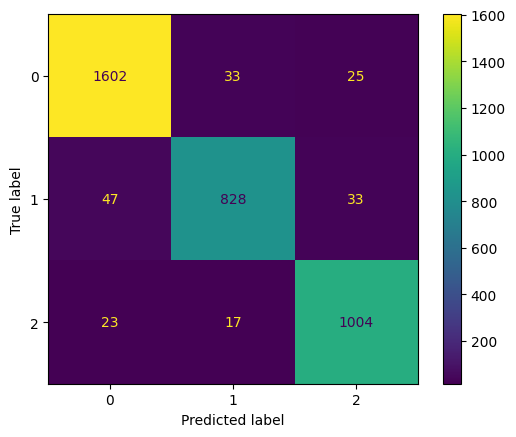

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy

confusion_matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [51]:
# all_labels = []
# for features_batch, labels_batch in test:
#     # Convert labels_batch to a NumPy array for easier manipulation
#     #print(labels_batch)
#     labels_numpy = labels_batch.numpy()
#     print(labels_numpy)
#     all_labels.extend(labels_numpy)